In [1]:
#import libraries (some of them may not be used)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import keras
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras import layers
from keras import initializers
from keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization,Embedding, LSTM, Reshape, Bidirectional,Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint
import wave
import os.path
from pathlib import Path
from keras import regularizers
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from tensorflow.keras.utils import to_categorical, custom_object_scope
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm, tqdm_pandas
import scipy
import librosa
import librosa.display
import json
from matplotlib.pyplot import specgram
import seaborn as sns
import glob
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
#Connecting to our google drive to access our data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Feature Extraction (20 MFCC features from Vowel /i/ in AVFAD dataset)

In [3]:
b1=[]
b2=[]
b3=[]

In [4]:
#extracting MFCC features from the train data and put them in a list whit their filenames

for file in glob.glob("/content/drive/MyDrive/train_01/train1/*.wav"):

        y1, sr1 = librosa.load(file, sr = None, mono=True)
        mfccs1= librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=20)
        filename1 = Path(file).stem
        x1 = filename1.split("_")
        b1.append([x1[0],mfccs1])

In [5]:
#extracting MFCC features from the validation data and put them in a list whit their filenames

for file in glob.glob("/content/drive/MyDrive/valid_01/validation1/*.wav"):

        y2, sr2 = librosa.load(file, sr = None, mono=True)
        mfccs2= librosa.feature.mfcc(y=y2, sr=sr2,n_mfcc=20)
        filename2 = Path(file).stem
        x2 = filename2.split("_")
        b2.append([x2[0],mfccs2])

In [6]:
#extracting MFCC features from the test data and put them in a list whit their filenames

for file in glob.glob("/content/drive/MyDrive/test_01/test1/*.wav"):

        y3, sr3 = librosa.load(file, sr = None, mono=True)
        mfccs3= librosa.feature.mfcc(y=y3, sr=sr3, n_mfcc=20)
        filename3 = Path(file).stem
        x3 = filename3.split("_")
        b3.append([x3[0],mfccs3])

Because the number of frames for each sample is differen, here we get the (Average + STD) of the frame numbers for the Dataset(train + valid + test).

In [7]:
f1 = []
f2 = []
f3 = []

In [8]:
for i in range (460):
  f1.append(len((b1[i][1]).T))
for i in range (105):
  f2.append(len((b2[i][1]).T))
for i in range (142):
  f3.append(len((b3[i][1]).T))

In [9]:
f4 = f1 + f2 + f3

In [10]:
F4 = np.array(f4)

In [11]:
ave = np.mean(F4)
s = np.std(F4)
print(min(F4))
print(ave)
print(s)
print(ave+s)

358
1388.980198019802
706.3238192613725
2095.3040172811743


Making X_train, X_test, X_validation and Y_train, Y_test, Y_validation

In [12]:
d1=[]
d2=[]
d3=[]

In [13]:
for i in range(460):
        d1.append([b1[i][0], ((b1[i][1]).T)[0:2095]])
for i in range(105):
        d2.append([b2[i][0], ((b2[i][1]).T)[0:2095]])
for i in range(142):
        d3.append([b3[i][0], ((b3[i][1]).T)[0:2095]])

In [14]:
data_train_MFCC =[]
data_valid_MFCC =[]
data_test_MFCC =[]

In [15]:
#we get our labels for each sample from this file

df = pd.read_csv('/content/drive/MyDrive/AVFAD_01_00_00.csv', encoding='ISO-8859-1')

In [16]:
for i in range(460):
    for j in range(709):
        if d1[i][0] == df.iloc[j,0]:
            data_train_MFCC.append([d1[i][0], d1[i][1], df.iloc[j,15]])

for i in range(105):
    for j in range(709):
        if d2[i][0] == df.iloc[j,0]:
            data_valid_MFCC.append([d2[i][0], d2[i][1], df.iloc[j,15]])

for i in range(142):
    for j in range(709):
        if d3[i][0] == df.iloc[j,0]:
            data_test_MFCC.append([d3[i][0], d3[i][1], df.iloc[j,15]])

In [17]:
data_train_MFCC.sort(key = lambda x: x[0])
data_valid_MFCC.sort(key = lambda x: x[0])
data_test_MFCC.sort(key = lambda x: x[0])

In [18]:
y_train = []
y_valid = []
y_test = []

In [19]:
x_train_MFCC = []
x_valid_MFCC = []
x_test_MFCC = []

In [20]:
for i in range(460):
    x_train_MFCC.append(data_train_MFCC[i][1])
for i in range(105):
    x_valid_MFCC.append(data_valid_MFCC[i][1])
for i in range(142):
    x_test_MFCC.append(data_test_MFCC[i][1])

In [21]:
for i in range(460):
    y_train.append(data_train_MFCC[i][2])
for i in range(105):
    y_valid.append(data_valid_MFCC[i][2])
for i in range(142):
    y_test.append(data_test_MFCC[i][2])

In [22]:
y_train = [0 if label == 'Normal' else 1 for label in y_train]
y_test = [0 if label == 'Normal' else 1 for label in y_test]
y_valid = [0 if label == 'Normal' else 1 for label in y_valid]

In [23]:
Y_train = np.array(y_train)
Y_valid = np.array(y_valid)
Y_test = np.array(y_test)

For having same frame numbers, here we add zero instead of features for samples that they have less frames than the 'Average + STD' of all samples' frame numbers.

In [24]:
z = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Z = np.array(z)
for i in range (20):
  Z[i]=np.float64(Z[i])

In [25]:
for i in range(460):
  for j in range(2095-len(x_train_MFCC[i])):
     x_train_MFCC[i] = np.append(x_train_MFCC[i], [Z], axis=0)
for i in range(105):
  for j in range(2095-len(x_valid_MFCC[i])):
     x_valid_MFCC[i] = np.append(x_valid_MFCC[i], [Z], axis=0)
for i in range(142):
  for j in range(2095-len(x_test_MFCC[i])):
     x_test_MFCC[i] = np.append(x_test_MFCC[i], [Z], axis=0)

In [26]:
X_train_MFCC = np.array(x_train_MFCC)
X_valid_MFCC = np.array(x_valid_MFCC)
X_test_MFCC = np.array(x_test_MFCC)

Normalization

In [27]:
import numpy as np

def z_score_normalize(data, mean=None, std=None):
    if mean is None:
        mean = np.mean(data, axis=(0, 1))
    if std is None:
        std = np.std(data, axis=(0, 1))
    normalized_data = (data - mean) / std
    return normalized_data, mean, std

# Calculate mean and std from train_data and normalize all datasets

X_train_MFCC, mean2, std2 = z_score_normalize(X_train_MFCC)
X_test_MFCC, _, _ = z_score_normalize(X_test_MFCC, mean2, std2)
X_valid_MFCC, _, _ = z_score_normalize(X_valid_MFCC, mean2, std2)

The Proposed Optomal CNN Model for Training our Dataset

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense

model_CNN_small = Sequential()
# Convolutional Layers
model_CNN_small.add(Conv2D(8, (3, 3), input_shape=(2095, 20, 1), activation='relu', padding='same'))
model_CNN_small.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN_small.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_CNN_small.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN_small.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN_small.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
model_CNN_small.add(GlobalAveragePooling2D())

# Regularization
model_CNN_small.add(Dropout(0.3))

# Fully Connected Layers
model_CNN_small.add(Dense(64, activation='relu'))
model_CNN_small.add(Dropout(0.2))

model_CNN_small.add(Dense(1, activation='sigmoid'))

# Compile the model
model_CNN_small.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_CNN_small.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 2095, 20, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1047, 10, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1047, 10, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 523, 5, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 523, 5, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 261, 2, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,065 (31.50 KB)

 Trainable params: 8,065 (31.50 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
#saving the trained model
filepath_MFCC = '/content/sample_data/model_test_MFCC.keras'
checkpoint = ModelCheckpoint(filepath=filepath_MFCC,
                             monitor='val_accuracy',
                             verbose=0,
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [37]:
import time
import subprocess


# Record the start time
start_time = time.time()

# Train the model
history = model_CNN_small.fit(X_train_MFCC, Y_train,
                        validation_data=(X_valid_MFCC, Y_valid),
                        batch_size=64, epochs=200,
                        callbacks=callbacks)

# Calculate total training time
total_time = time.time() - start_time


# Print the results
print(f"Total training time: {total_time:.2f} seconds")


Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.4955 - loss: 0.6978 - val_accuracy: 0.4762 - val_loss: 0.6847
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5050 - loss: 0.6913 - val_accuracy: 0.7524 - val_loss: 0.6826
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5191 - loss: 0.6877 - val_accuracy: 0.7905 - val_loss: 0.6791
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6015 - loss: 0.6807 - val_accuracy: 0.6857 - val_loss: 0.6700
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6107 - loss: 0.6817 - val_accuracy: 0.8095 - val_loss: 0.6577
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6239 - loss: 0.6718 - val_accuracy: 0.7905 - val_loss: 0.6355
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5846 - loss: 0.6636 - val_accuracy: 0.8190 - val_loss: 0.6124
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6454 - loss: 0.6454 - val_accuracy: 0.7429 - val_loss

Accuracies of the model for test and validation data by MFCC Features for vowel /i/

In [38]:
from keras.models import load_model

model = load_model(filepath_MFCC)

In [39]:
test_loss, test_acc = model.evaluate(X_valid_MFCC,Y_valid, verbose=0)
print("validation Accuracy by MFCC: ",test_acc)

validation Accuracy by MFCC:  0.8857142925262451


In [40]:
test_loss, test_acc = model.evaluate(X_test_MFCC,Y_test, verbose=0)
print("Test Accuracy by MFCC: ",test_acc)

Test Accuracy by MFCC:  0.8943662047386169


Training Accuracy Plot

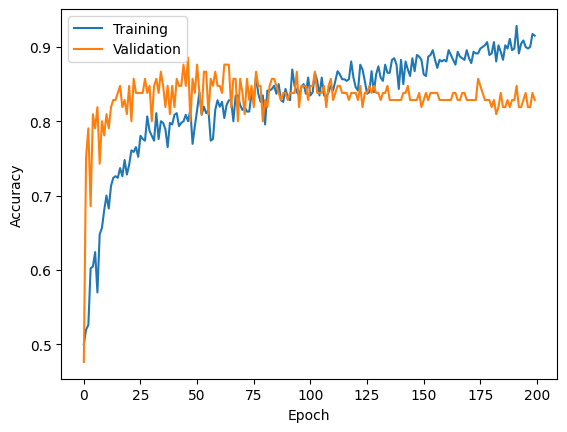

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [42]:
y_pred=model.predict(X_test_MFCC)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


Reporting Precision, Recall, and F1-Score for Healthy and Unhealthy Samples

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(Y_test, y_pred.round()))
print(classification_report(Y_test, y_pred.round()))

[[61 11]
 [ 4 66]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        72
           1       0.86      0.94      0.90        70

    accuracy                           0.89       142
   macro avg       0.90      0.90      0.89       142
weighted avg       0.90      0.89      0.89       142

